## NeuroMANCER and Dependencies

In [1]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

In [10]:
# Double integrator parameters
nx = 2
nu = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# linear state space model
xnext = lambda x, u: x @ A.T + u @ B.T    
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')

# neural control policy
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

# closed loop system definition
cl_system = System([policy, double_integrator])

# Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the system operates in. 

In [20]:
# Training dataset generation
train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3333,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=3333,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

# Optimization problem

We want to learn a controller that stabilizes the double integrator system. In other words we would like a control policy that pushes the system to stay at the origin. 

In [22]:
# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.0001 * (u == 0.)^2  # control penalty
regulation_loss = 10. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Optimize problem with a system rollout of 2 time steps


In [30]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=400,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)

# Train model with prediction horizon of 2
cl_system.nsteps = 2
best_model = trainer.train()

/Users/tommy/anaconda3/envs/MPCritic/lib/python3.10/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
/Users/tommy/anaconda3/envs/MPCritic/lib/python3.10/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 3, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 199.7594451904297
epoch: 1  train_loss: 199.27536010742188
epoch: 2  train_loss: 198.8117218017578
epoch: 3  train_loss: 198.3619384765625
epoch: 4  train_loss: 197.9244384765625
epoch: 5  train_loss: 197.5006866455078
epoch: 6  train_loss: 197.08865356445312
epoch: 7  train_loss: 196.6795654296875
epoch: 8  train_loss: 196.25973510742188
epoch: 9  train_loss: 195.82333374023438
epoch: 10  train_loss: 195.365478515625
epoch: 11  train_loss: 194.88546752929688
epoch: 12  train_loss: 194.37884521484375
epoch: 13  train_loss: 193.84300231933594
epoch: 14  train_loss: 193.27499389648438
epoch: 15  train_loss: 192.67137145996094
epoch: 16  train_loss: 192.02886962890625
epoch: 17  train_loss: 191.34432983398438
epoch: 18  train_loss: 190.61480712890625
epoch: 19  train_loss: 189.83644104003906
epoch: 20  train_loss: 189.00836181640625
epoch: 21  train_loss: 188.12899780273438
epoch: 22  train_loss: 187.1966552734375
epoch: 23  train_loss: 186.20896911621094
epoch: 24  

# Evaluate best model on a system rollout 


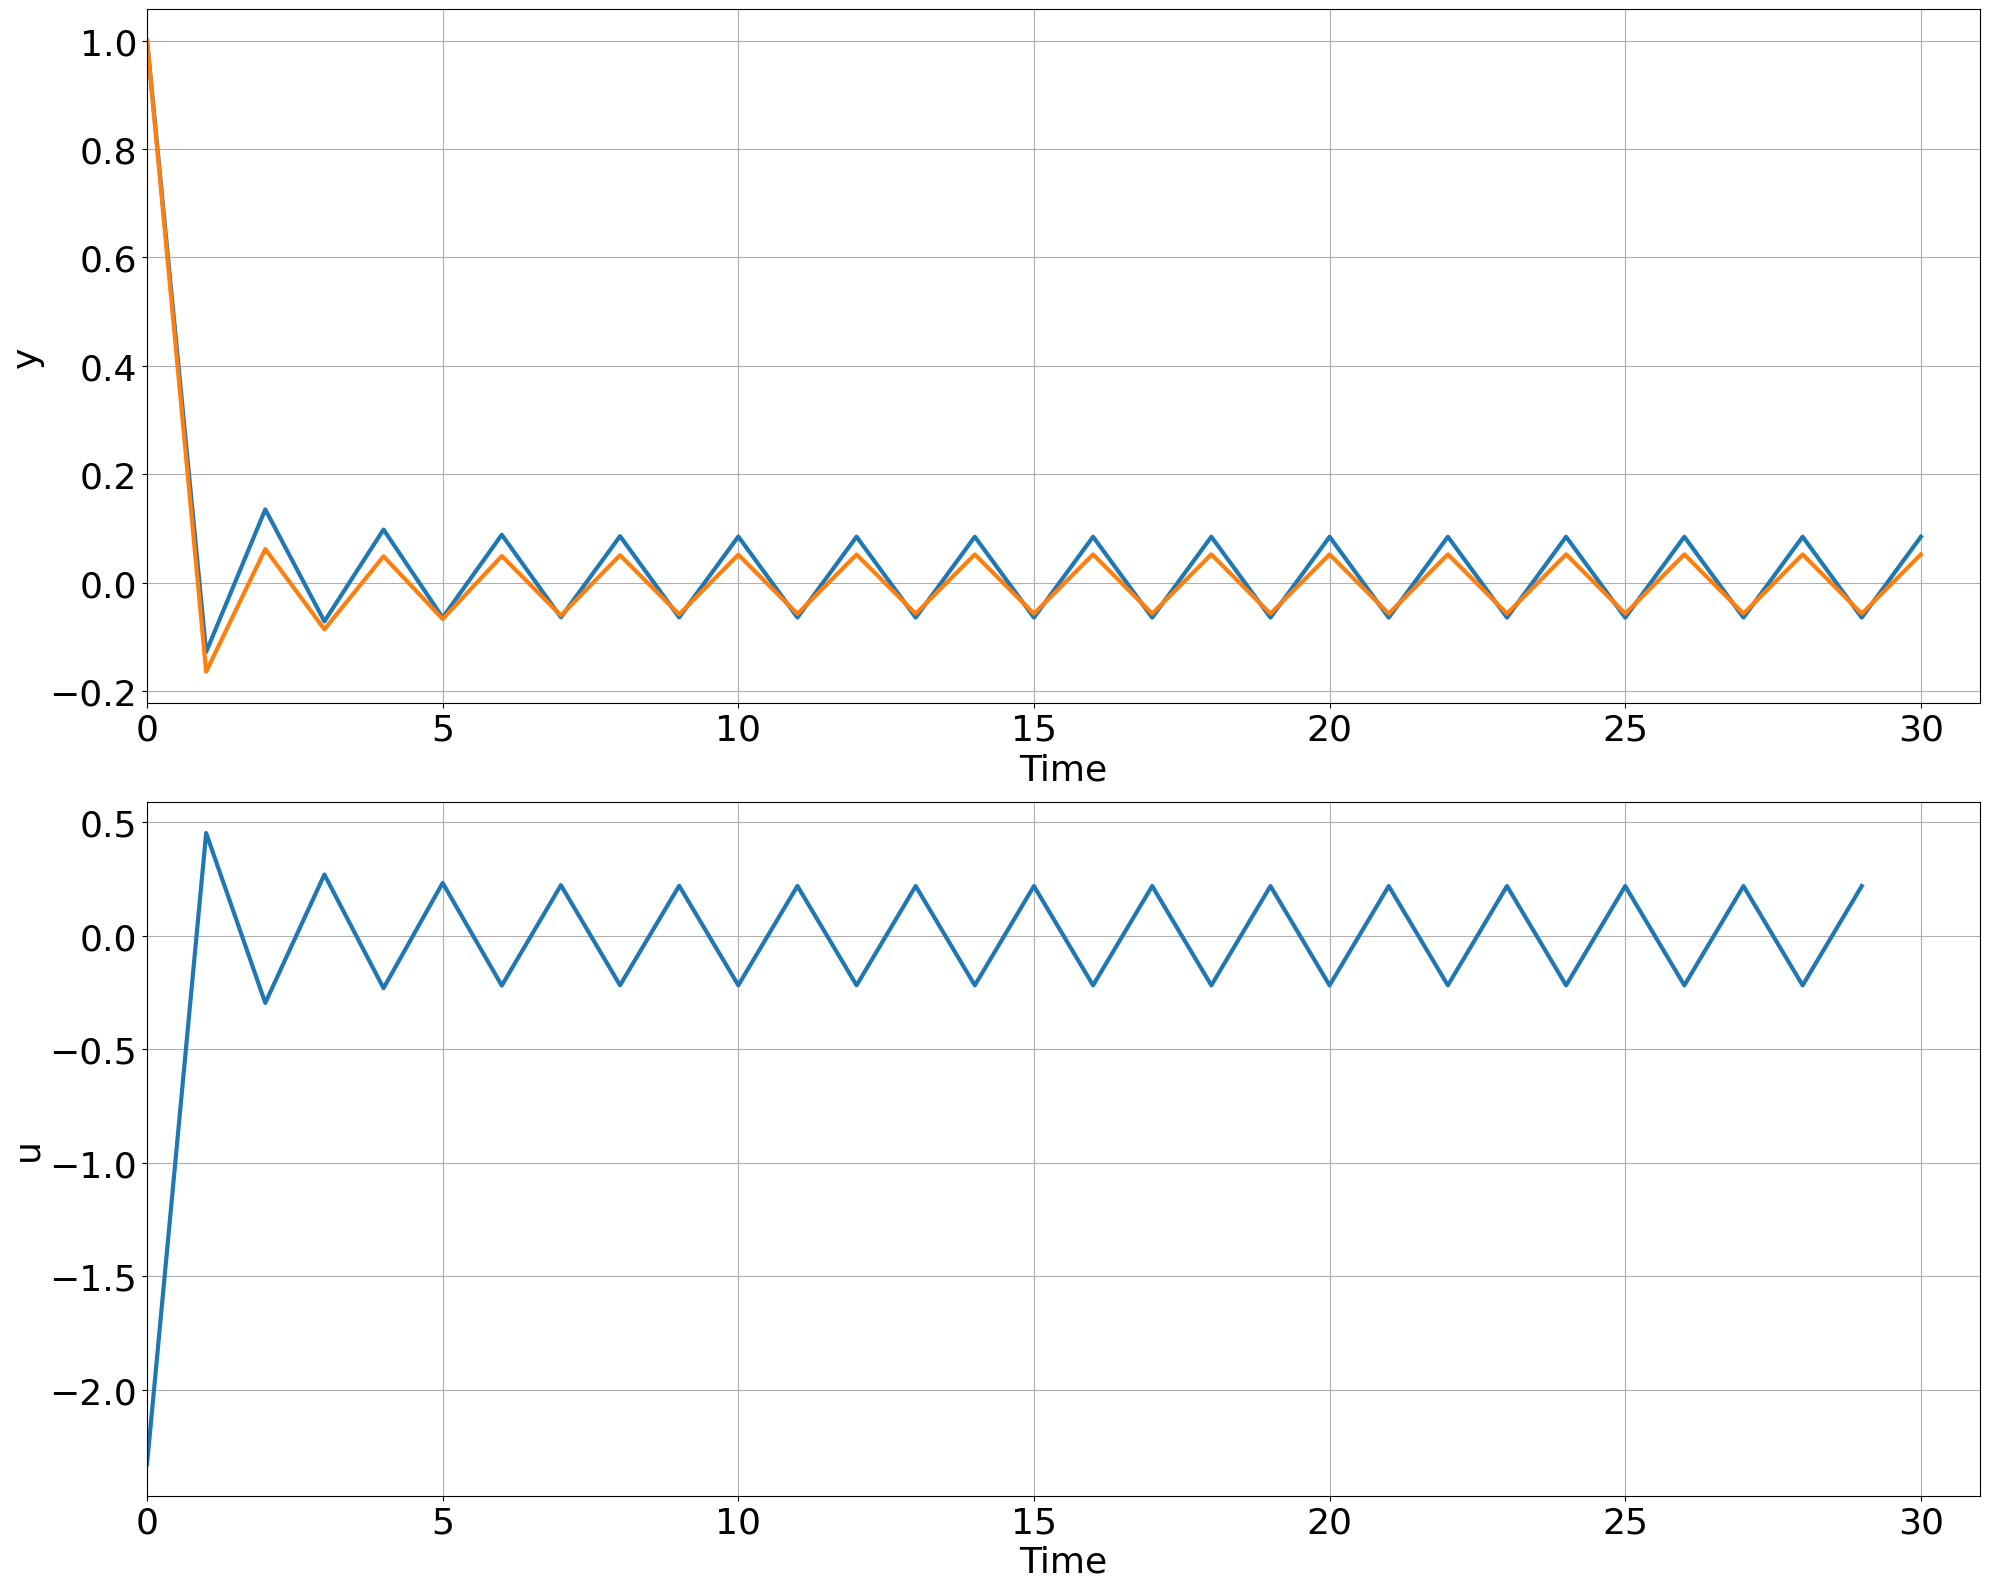

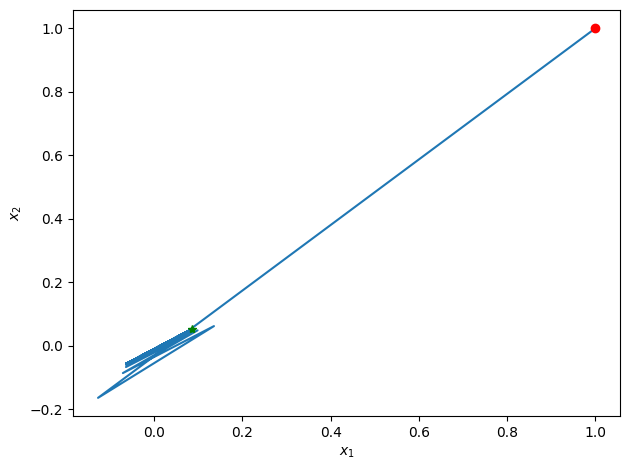

<Figure size 640x480 with 0 Axes>

In [31]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)
data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
nsteps = 30
cl_system.nsteps = nsteps
trajectories = cl_system(data)
pltCL(Y=trajectories['X'].detach().reshape(nsteps+1, 2), U=trajectories['U'].detach().reshape(nsteps, 1), figname='cl.png')
pltPhase(X=trajectories['X'].detach().reshape(nsteps+1, 2), figname='phase.png')